In [110]:
import torch
import os, sys, json, cv2, random, torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import seaborn as sns
from PIL import Image
from numpy import interp
import warnings
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchinfo import summary
from sklearn.metrics import auc, f1_score, roc_curve, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from itertools import cycle

In [2]:
os.listdir('D:/flower_data')

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
root = 'D:/flower_data'
classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]

In [6]:
{k: v for v, k in enumerate(classes)}

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [7]:
for klass in classes:
    classpath = os.path.join(root, klass)
    print(classpath)

D:/flower_data\daisy
D:/flower_data\dandelion
D:/flower_data\roses
D:/flower_data\sunflowers
D:/flower_data\tulips


In [10]:
os.path.splitext('100080576_f52e8ee070_n.jpg')[-1]

'.jpg'

In [11]:
os.path.join(root, 'daisy')

'D:/flower_data\\daisy'

In [17]:
fl = 'D:/flower_data/daisy/100080576_f52e8ee070_n.jpg'.lower()

In [18]:
fl

'd:/flower_data/daisy/100080576_f52e8ee070_n.jpg'

In [19]:
fl.rfind('.')

43

In [24]:
fl[43:]

'.jpg'

In [36]:
img = cv2.imread('D:/flower_data/daisy/100080576_f52e8ee070_n.jpg')

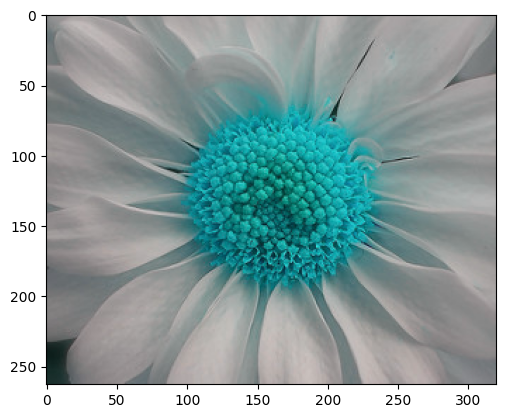

In [37]:
plt.imshow(img)

In [38]:
img.shape

(263, 320, 3)

In [41]:
def read_split_data(root, plot_image=False):
    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    assert os.path.exists(root), 'Your root path: {} is not exist!!'.format(root)

    # ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG', '.tiff', '.TIFF']

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))

        flist = sorted(os.listdir(classpath))

        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    print(f'{len(df.labels.unique())} kind of images were found in the dataset')
    train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    train_image_path = train_df['filepaths'].tolist()
    val_image_path = test_df['filepaths'].tolist()

    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    val_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('{} images were found in the dataset.\n{} for training, {} for validation'.format(
        sum(every_class_num), len(train_image_path), len(val_image_path)
    ))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center')
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, val_image_path, val_image_label, class_indices

tulips                 : 100%|███████████████████████████████████████████| 799/799 [00:01<00:00, 582.85file/s]


5 kind of images were found in the dataset
3670 images were found in the dataset.
2936 for training, 734 for validation
average image height=  268   average image width=  347  aspect ratio h/w=  0.7723342939481268


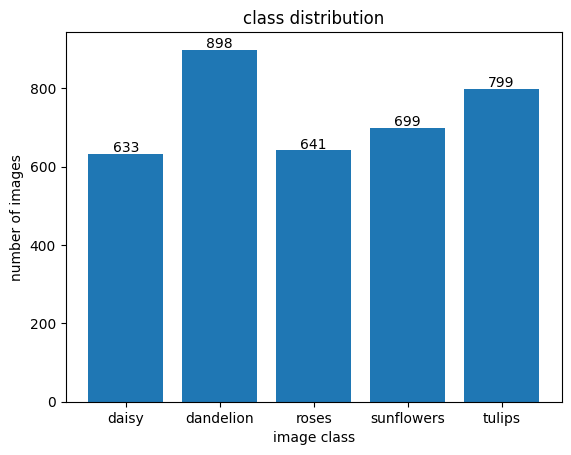

In [42]:
train_image_path, train_image_label, val_image_path, val_image_label, class_indices = read_split_data(root='D:/flower_data', plot_image=True)

In [55]:
class MyDataset(Dataset):

    def __init__(self, image_path, image_labels, transform=None):
        
        assert len(image_path) == len(image_labels), "Your image_path's length does not equal image_label's length"
        
        self.image_path = image_path
        self.image_class = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item):
        # 转成RGB格式
        img = Image.open(self.image_path[item]).convert('RGB')
        label = self.image_class[item]

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    # DataLoader 方法会用到 如果不设置 则使用官方默认的
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [56]:
batch_size = 8  # occupy 3976MB gpu memory
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
lr = 0.001
weight_decay = 1e-5
save_path = './MyAlexNet.pth'

data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(),
                                 transforms.RandomHorizontalFlip(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'valid': transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop(224),
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

In [57]:
train_dataset = MyDataset(train_image_path, train_image_label, data_transform['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform['valid'])
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=valid_dataset.collate_fn)

In [58]:
image, label = next(iter(train_dataset))

In [60]:
image.shape

torch.Size([3, 224, 224])

In [62]:
label

1

In [63]:
image, label = next(iter(train_loader))

In [64]:
image.shape

torch.Size([8, 3, 224, 224])

In [65]:
label.shape

torch.Size([8])

In [66]:
len(train_dataset)

2936

In [70]:
len(train_loader)

367

In [68]:
torch.cuda.is_bf16_supported()

False

In [71]:
def train_step(net, optimizer, data_loader, device, epoch, scalar=None):
    net.train()
    loss_function = nn.CrossEntropyLoss()
    train_acc, train_loss, sampleNum = 0, 0, 0
    optimizer.zero_grad()

    train_bar = tqdm(data_loader, file=sys.stdout, colour='red')
    for step, data in enumerate(train_bar):
        images, labels = data
        sampleNum += images.shape[0]  # batch
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if scalar is not None:
            with torch.cuda.amp.autocast():
                outputs = net(images)
                loss = loss_function(outputs, labels)
        else:
            outputs = net(images)
            loss = loss_function(outputs, labels)

        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_loss += loss.item()
        # loss.backward()
        # optimizer.step()

        if scalar is not None:
            scalar.scale(loss).backward()
            scalar.step(optimizer)
            scalar.update()
        else:
            loss.backward()
            optimizer.step()
        train_bar.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch, train_loss / (step + 1),
                                                                             train_acc / sampleNum)

    return train_loss / (step + 1), train_acc / sampleNum


@torch.no_grad()
def val_step(net, data_loader, device, epoch):
    loss_function = nn.CrossEntropyLoss()
    net.eval()
    val_acc = 0
    val_loss = 0
    sample_num = 0
    val_bar = tqdm(data_loader, file=sys.stdout, colour='red')
    for step, data in enumerate(val_bar):
        images, labels = data
        sample_num += images.shape[0]
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        val_bar.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch, val_loss / (step + 1),
                                                                           val_acc / sample_num)

    return val_loss / (step + 1), val_acc / sample_num


def Plot_ROC(net, val_loader, save_name, device):
    try:
        json_file = open('./classes_indices.json', 'r')
        class_indict = json.load(json_file)
    except Exception as e:
        print(e)
        exit(-1)

    score_list = []  # 存储预测得分
    label_list = []  # 存储真实标签

    net.load_state_dict(torch.load(save_name)['model'])

    for i, data in enumerate(val_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = torch.softmax(net(images), dim=1)
        score_tmp = outputs
        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], len(class_indict.keys()))
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)

    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(len(class_indict.keys())):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(class_indict.keys()))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(set(label_list))):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

    # Finally average it and compute AUC
    mean_tpr /= len(class_indict.keys())
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

    # 绘制所有类别平均的roc曲线
    plt.figure(figsize=(12, 12))
    lw = 2

    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(class_indict.keys())), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_indict[str(i)], roc_auc_dict[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance', color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('./multi_classes_roc.png')

In [103]:
test_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=3),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
    nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
    nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2),
    nn.Flatten(start_dim=1)
)

In [104]:
summary(test_model, input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [8, 9216]                 --
├─Conv2d: 1-1                            [8, 96, 55, 55]           34,944
├─MaxPool2d: 1-2                         [8, 96, 27, 27]           --
├─Conv2d: 1-3                            [8, 256, 27, 27]          221,440
├─MaxPool2d: 1-4                         [8, 256, 13, 13]          --
├─Conv2d: 1-5                            [8, 384, 13, 13]          885,120
├─Conv2d: 1-6                            [8, 384, 13, 13]          1,327,488
├─Conv2d: 1-7                            [8, 256, 13, 13]          884,992
├─MaxPool2d: 1-8                         [8, 256, 6, 6]            --
├─Flatten: 1-9                           [8, 9216]                 --
Total params: 3,353,984
Trainable params: 3,353,984
Non-trainable params: 0
Total mult-adds (G): 6.33
Input size (MB): 4.82
Forward/backward pass size (MB): 41.61
Params size (MB): 13.42
Estimated To

In [105]:
class MyAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.act1 = nn.ReLU(inplace=True)
        self.max_pool1 = nn.MaxPool2d(2, 2) # [B, C, 55, 55] ---> [B, C, 27, 27]
        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.act2 = nn.ReLU(inplace=True)
        self.max_pool2 = nn.MaxPool2d(2, 2)# [B, C, 27, 27] ---> [B, C, 13, 13]
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.act3 = nn.ReLU(inplace=True)
        
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.act4 = nn.ReLU(inplace=True)
        
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.act5 = nn.ReLU(inplace=True)
        self.max_pool3 = nn.MaxPool2d(2, 2) # [B, C, 13, 13] --->  [B, C, 6, 6] 
        
        self.head = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(9216, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, 5)
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.act5(x)
        x = self.max_pool3(x)
        
        y = self.head(x)
        
        return y

In [106]:
net = MyAlexNet()

In [107]:
summary(net, input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MyAlexNet                                [8, 5]                    --
├─Conv2d: 1-1                            [8, 96, 55, 55]           34,944
├─BatchNorm2d: 1-2                       [8, 96, 55, 55]           192
├─ReLU: 1-3                              [8, 96, 55, 55]           --
├─MaxPool2d: 1-4                         [8, 96, 27, 27]           --
├─Conv2d: 1-5                            [8, 256, 27, 27]          221,440
├─BatchNorm2d: 1-6                       [8, 256, 27, 27]          512
├─ReLU: 1-7                              [8, 256, 27, 27]          --
├─MaxPool2d: 1-8                         [8, 256, 13, 13]          --
├─Conv2d: 1-9                            [8, 384, 13, 13]          885,120
├─BatchNorm2d: 1-10                      [8, 384, 13, 13]          768
├─ReLU: 1-11                             [8, 384, 13, 13]          --
├─Conv2d: 1-12                           [8, 384, 13, 13]          1

In [113]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
best_val_acc = 0.0
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.33)

In [114]:
for epoch in range(epochs):
    # train [net, optimizer, data_loader, device, epoch]
    train_loss, train_accuracy = train_step(net=net,
                                       optimizer=optimizer,
                                       data_loader=train_loader,
                                       device=device,
                                       epoch=epoch)

    # validate [net, data_loader, device, epoch]
    val_loss, val_accuracy = val_step(net=net,
                                 data_loader=valid_loader,
                                 device=device,
                                 epoch=epoch)

    lr_scheduler.step()

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        save_file = {"model": net.state_dict(),
                     "optimizer": optimizer.state_dict(),
                     "lr_scheduler": lr_scheduler.state_dict(),
                     }
        torch.save(save_file, save_path)

[valid epoch 9] loss: 1.106, acc: 0.508: 100%|█████████████████████████████████████████| 92/92 [00:02<00:00, 33.13it/s]


score_array: (734, 5)
label_onehot: (734, 5)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15240\2593083688.py:140: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance', color='red')


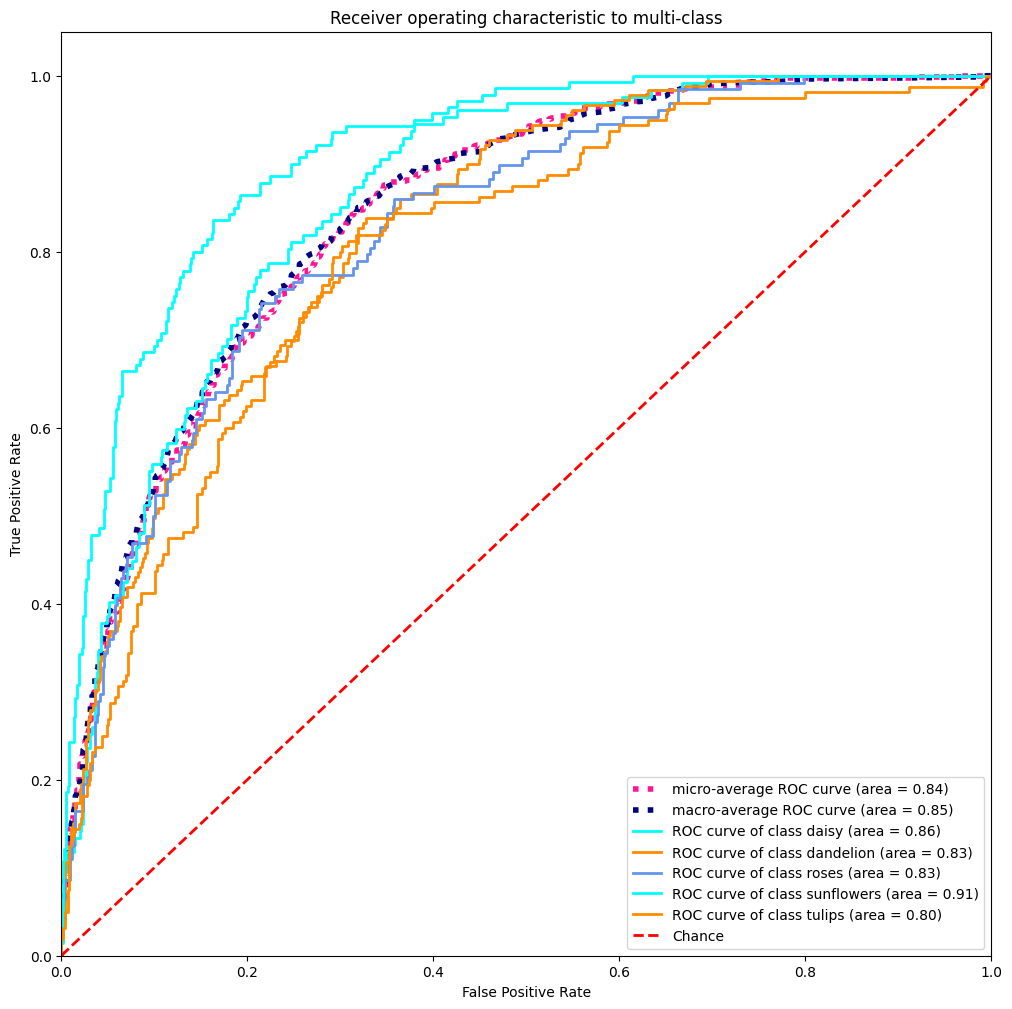

In [115]:
Plot_ROC(net, valid_loader, save_path, device)